# L2 - Multilayer perceptron

### Papers
1. [TensorFlow](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/45166.pdf)

### TensorFlow
1. [Installing TensorFlow](https://www.tensorflow.org/install/)
2. [Basics of TensorFlow](https://www.tensorflow.org/get_started/get_started)
3. [Mnist with TensorFlow](https://www.tensorflow.org/get_started/mnist/pros)
4. [TensorFlow Mechanics](https://www.tensorflow.org/get_started/mnist/mechanics)
5. [Visualization](https://www.tensorflow.org/get_started/graph_viz)


### One more thing
1. [Jupyter tutorial](https://habrahabr.ru/company/wunderfund/blog/316826/)
2. [Plot.ly](https://plot.ly/python/)
3. [Widgets](http://jupyter.org/widgets.html)

### 1. Linear multi-classification problem

We have already learned binary linear classifier
$$y = \text{sign}(w^Tx).$$
There are [several approaches](https://en.wikipedia.org/wiki/Multiclass_classification) to solve the problem of multi-class classification. For example [reduction](https://en.wikipedia.org/wiki/Multiclass_classification#Transformation_to_Binary) of problem to binary classifier or [modification](https://en.wikipedia.org/wiki/Support_vector_machine#Multiclass_SVM) of the known model. However we are interested in approaches that is applied in neural networks.

For each class $c \in 1, \dots, |C|$ we have an individual row $w_i$ of matrix $W$. Then the probability of $x$ belonging to a particular class is equal to
$$p_i = \frac{\exp(w^T_ix)}{\sum_j \exp(w^T_jx)}.$$
This is nothing, but [softmax](https://en.wikipedia.org/wiki/Softmax_function) function of $Wx$.
$$(p_1, \dots, p_{|C|}) = \text{softmax}(Wx).$$

If you look closely, $\text{softmax}$ is a more general variant of sigmoid. To see this, it suffices to consider the case $|C|=2$. As usual the training can be reduced to minimization of the empirical risk, namely, optimization problem
$$\arg\min_W Q(W) = \arg\min_W -\frac{1}{\mathcal{l}}\sum_y\sum_i [y = i] \cdot \ln(p_i(W)).$$
Actually, the maximization of the log-likelihood is written above.

#### Exercises
1. Find $\frac{dQ}{dW}$ in matrix form (hint: start with $\frac{dQ}{dw_i}$ for begining).
2. Please plot several mnist images (e.g using grid 5x5).
3. Train linear multi-label classifier for [mnist](https://www.kaggle.com/c/digit-recognizer) dataset with TensorFlow (possible, [this tutorial](https://www.tensorflow.org/get_started/mnist/pros) can help you).
4. Chek accuracy on train and validation sets.
5. Use a local [TensorBoard instance](https://www.tensorflow.org/get_started/graph_viz) to visualize resulted graph (no need to include in lab).

In [1]:
#Подключим все необходимые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import time

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
#Загрузим данные
data = np.array(pd.read_csv('data/train.csv'), dtype=np.float32)
labels = np.array(data[:, 0], dtype=np.int32)
data = data[:, 1:]
data /= 256.0

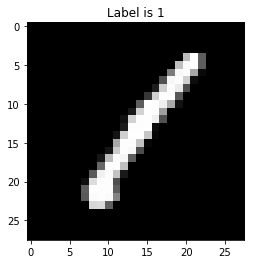

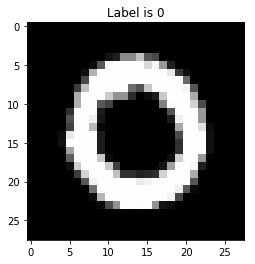

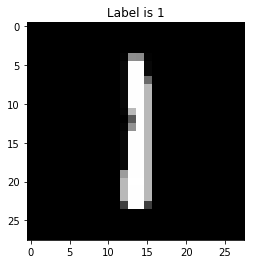

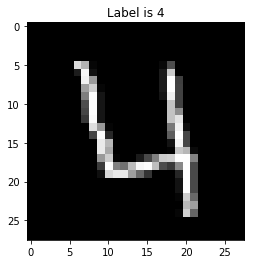

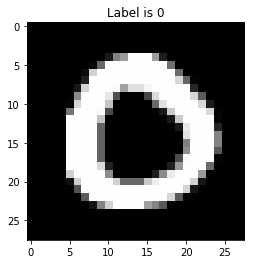

In [3]:
#Примеры картинок
for i in range(5):
    img = np.array(data[i]).reshape((28, 28))
    plt.title('Label is ' + str(labels[i]))
    plt.imshow(img, cmap='gray')
    plt.show()

In [4]:
#Напишем несколько функций
#Просто мешает данные
def shuffle(X, Y):
    shuffle = np.random.permutation(X.shape[0])
    return X[shuffle], Y[shuffle]

#Разделяет наши данные на train и на test
# и при необходимости использует кросс-валидацию
def cross_validation(X, Y, parts, cross_valid=True):
    X, Y = shuffle(X, Y)
    for i in range(parts):
        l = i * X.shape[0] // parts
        r = (i + 1) * X.shape[0] // parts
        test = np.zeros(X.shape[0], dtype=np.bool)
        test[l:r] = True
        if cross_valid or i == 0 :
            yield X[~test], Y[~test], X[test], Y[test]
#Берет из данных батчи
def next_batch(X, Y, batch_size):
    for i in range(0, X.shape[0], batch_size):
        j = min(i + batch_size, X.shape[0])
        yield X[i:j], Y[i:j]


In [5]:
#Определяем входные данные: картинки и лейблы
x = tf.placeholder(tf.float32, shape=[None, 784], name="data")
y_labels = tf.placeholder(tf.int32, shape=[None], name="labels")

#Построим один слой
y = tf.layers.dense(inputs=x,
                    units=10,
                    use_bias=True,
                   )

#Функция потерь (softmax)
cross_entropy = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_labels, logits=y))

#Будем использовать градиентный спуск
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

#Считаем количество правильных предсказаний
correct_prediction = tf.equal(tf.argmax(y, 1, output_type=tf.int32), y_labels)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [6]:
batch_size = 64
acc_test = 0.0
acc_train = 0.0
parts = 5
epoches = 1
start = time.time()

#В сессии проходим кросс-валидацией по всему дата-сету
with tf.Session() as sess:
    for X_train, Y_train, X_test, Y_test in cross_validation(data, labels, parts):
        #Инициализируем переменные
        sess.run(tf.global_variables_initializer())
        #Проходим нужное кол-во эпох
        for i in range(epoches):
            #И для каждого батча делаем шаг в градиентном спуске
            for batch_x, batch_y in next_batch(X_train, Y_train, batch_size):
                sess.run(train_step, feed_dict={x: batch_x, y_labels: batch_y})

        #Считаем каждый раз долю верно предсказанных
        acc_train += sess.run(accuracy, feed_dict={x: X_train, y_labels: Y_train})
        acc_test += sess.run(accuracy, feed_dict={x: X_test, y_labels: Y_test})
    
    #Считаем среднее
    acc_test /= parts
    acc_train /= parts

print(time.time() - start)
print("Accuracy on train set =", acc_train)
print("Accuracy on test set =", acc_test)
print("___________________________________")


32.6205997467041
Accuracy on train set = 0.912541663647
Accuracy on test set = 0.907166659832
___________________________________


Let's briefly touch on themes of regularization. As was discussed before, there are different approaches. We focus on the modification of loss function.

$$\arg\min_W -\frac{1}{\mathcal{l}}\sum_y\sum_i [y = i] \cdot \ln(p_i(W)) + \lambda_1 L_1(W) + \lambda_2 L_2(W)$$

1. $L_1(W) = sum_{i,j} |w_{i,j}|$ - sparsify weights (force to not use uncorrelated features)
2. $L_2(W) = sum_{i,j} w_{i,j}^2$ - minimize weights (force to not overfit)

#### Exercises
1. Train model again using both type of regularization.
2. Plot matrix of weights.
3. Which pixels have zero weights? What does it mean?
4. Have you improved accuracy on validation?

In [7]:
# теперь добавим регулизацию в наши слои
y = tf.layers.dense(
        inputs=x,
        units=10,
        use_bias=True,
        kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(
            scale_l1=1e-4,
            scale_l2=1e-4
        )
)

#И добавим регулизацию в функцию потерь
cross_entropy = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_labels, logits=y)) \
    + tf.losses.get_regularization_loss()

#все остальное аналогично

train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y, 1, output_type=tf.int32), y_labels)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [8]:
batch_size = 64
epoches = 5
parts = 5
acc_train = 0.0
acc_test = 0.0
cross_valid = False
with tf.Session() as sess:
    for X_train, Y_train, X_test, Y_test in cross_validation(data,
                                                             labels,
                                                             parts,
                                                             cross_valid=cross_valid
                                                            ):
        sess.run(tf.global_variables_initializer())
        for i in range(epoches):
            for batch_x, batch_y in next_batch(X_train, Y_train, batch_size):
                sess.run(train_step, feed_dict={x: batch_x, y_labels: batch_y})

        acc_train += sess.run(accuracy, feed_dict={x: X_train, y_labels: Y_train})
        acc_test += sess.run(accuracy, feed_dict={x: X_test, y_labels: Y_test})
    
    if cross_valid:
        acc_train /= parts
        acc_test /= parts

    print("Accuracy on train set =", acc_train)
    print("Accuracy on test set =", acc_test)

Accuracy on train set = 0.920059502125
Accuracy on test set = 0.916071414948


### 2. Universal approximation theorem

What if we add more layers to our model? Namely, we train two matrix $W_2$ and $W_1$
$$softmax(W_2\cdot(W_1x)).$$

At first glance adding more parameters helps to increase the generalizing ability of the model. Buy actually we have the same model $softmax(Wx)$, where $W = W_2\cdot W_1$. But everyting changes with adding ome more layer. Let's add nonlinear function $\sigma$ between $W_2$ and $W_1$

$$softmax(W_2\cdot \sigma(W_1x)).$$

Kurt Hornik showed in 1991 that it is not the specific choice of the nonlinear function, but rather the multilayer feedforward architecture itself which gives neural networks the potential of being universal approximators. The output units are always assumed to be linear. For notational convenience, only the single output case will be shown. The general case can easily be deduced from the single output case.

Let $\sigma(\cdot)$ be a nonconstant, bounded, and monotonically-increasing continuous function.
Let $\mathcal{S}_m \subset \mathbb{R}^m$ denote any compact set. 
Then, given any $\varepsilon > 0$ and any coninuous function $f$ on $\mathcal{S}_m$, there exist an integer $N$ and real constants $v_i$, $b_i$ amd real vectors $w_i$ that

$$\left| \sum _{i=1}^{N}v_{i}\sigma \left( w_i^{T} x+b_i \right) - f(x) \right| < \varepsilon, ~~~ \forall x \in \mathcal{S}_m.$$

The theorem has non-constructive proof, it meams that no estimates for $N$ and no method to find approximation's parameters.

#### Exercises
1. Let $\sigma$ – [heaviside step function](https://en.wikipedia.org/wiki/Heaviside_step_function) and $x \in \{0, 1\}^2$. Prove that $y = \sigma(wx + b)$ can approximate boolean function **OR** (hint: use constructive proof).
2. What about **AND** function?
3. Is it possible to implement **XOR**? Prove your words.
4. Prove that 2-layer network can implement any boolean function.

#### More useful facts:
1. A 2-layer network in in $\mathbb{R}^n$ allows to define convex polyhedron..
2. A 3-layer network in в $\mathbb{R}^n$ allows to define a not necessarily convex and not even necessarily connected area.

### 3. Backpropagation
Backpropagation is a method used to calculate the error contribution of each layer after a batch of data. It is a special case of an older and more general technique called automatic differentiation. In the context of learning, backpropagation is commonly used by the gradient descent optimization algorithm to adjust the weight of layers by calculating the gradient of the loss function. This technique is also sometimes called backward propagation of errors, because the error is calculated at the output and distributed back through the network layers. The main motivation of method is simplify evaluation of gradient which is complex problem for multilayer nets.

We need the following notation. Let $(y^1,\dots,y^n) = f(x^1,\dots,x^n)$ is some differentiable function and $\frac{dy}{dx}$ is matrix
$$\frac{dy}{dx} = \Big[ J_{ij} = \frac{\partial y^i}{\partial x^j} \Big]$$

Without violating the generality, we can assume that each layer is a function $x_{i} = f(x_{i-1}, w_i)$. As last layer we add loss function, so we can assume our multi-layer net as function $Q(x_0) = Q(f_n(f_{n-1}(\dots, w_{n-1}), w_n))$.

#### Forward step
Propagation forward through the network to generate the output values. Calculation of the loss function.

#### Backward step
Let's look at last layer. We can simply find $\frac{dQ}{dx_n}$. Now we can evaluate 

$$\frac{dQ}{dw_n} = \frac{dQ}{dx_n}\frac{dx_n}{dw_n} \text{ and } \frac{dQ}{dx_{n-1}} = \frac{dQ}{dx_n}\frac{dx_n}{dx_{n-1}}$$

Now we need calculate $\frac{dQ}{dw_{n-2}}$ и $\frac{dQ}{dx_{n-2}}$. But we have the same situation. We know $\frac{dQ}{dx_k}$, so can evaluate $\frac{dQ}{dw_k}$ and $\frac{dQ}{dx_{k-1}}$. Repeating this operation we find all the gradients. Now it's only remains to make a gradient step to update weights.

#### Exercises
1. Read more about [vanishing gradient](https://en.wikipedia.org/wiki/Vanishing_gradient_problem).
2. Train 2 layer net. Use sigmoid as nonlinearity.
3. Check accuracy on validation set.
4. Use [ReLu](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) or LeakyReLu as nonlinearity. Compare accuracy and convergence with previous model.
5. Play with different architectures (add more layers, regularization and etc).
6. Show your best model.
7. How does quality change with adding layers. Prove your words, train model for 2, 3, 5, 7 and 10 layers.
8. Using backpropagation find optimal  digit 8 for your net.*

In [9]:
#Напишем сложную функцию, которая считает долю верно предсказанных
def compute_accuracy(
        sizes=[784, 10],          # Размеры промежуточных слоев
        nonlinearity="leakyrelu", # Нелинейность между слоями
        alpha=0.1,                # Коэффициент альфа для LeakyReLU
        lambda1 = 0.0,            # Коэффициент при регулизации L1
        lambda2 = 0.0,            # Коэффициент при регулизации L2
        grad_speed=0.5,           # Коэффициент градиентного спуска
        epoches=5,                # Количество эпох
        batch_size=64,            # Размер батча
        parts=5,                  # Количетсво частей,
                                    # на которые мы делим данные при кросс-валидации
        cross_valid=True          # Флаг использования кросс-валидации(проверка на всех частях)
):
    # Удалим предыдущие переменные и граф
    tf.get_variable_scope().reuse_variables()
    tf.reset_default_graph()

    # Сделаем так, чтобы первый слой был размера 784, а последний - 10
    if sizes[0] != 784:
        sizes.insert(0, 784)
    if sizes[-1] != 10:
        sizes.append(10)

    # Количество слоев
    n = len(sizes)
    
    # Определим функцию активации (нелинейность между слоями)
    activation = 0
    if nonlinearity == "sigmoid":
        activation = tf.nn.sigmoid
    elif nonlinearity == "relu":
        activation = tf.nn.relu
    elif nonlinearity == "leakyrelu":
        def leaky_relu(features):
            return tf.nn.relu(features) - alpha * tf.nn.relu(features)
        activation = leaky_relu
    else:
        raise RuntimeError("I don't know this function")

    # Определение переменных
    x = tf.placeholder(tf.float32, shape=[None, 784], name="data")
    y_labels = tf.placeholder(tf.int32, shape=[None], name="labels")
    
    # Добавим слои в цикле в список (кроме последнего)
    x_interim = list()
    x_interim.append(x)
    for i in range(1, n - 1):
        if lambda1 == 0 and lambda2 == 0:
            x_interim.append(
                tf.layers.dense(
                    inputs=x_interim[i - 1],
                    units=sizes[i],
                    activation=activation,
                    use_bias=True,
                    name="x" + str(i)
                )
            )
        else:
            x_interim.append(
                tf.layers.dense(
                    inputs=x_interim[i - 1],
                    units=sizes[i],
                    activation=activation,
                    use_bias=True,
                    kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(
                        scale_l1=lambda1,
                        scale_l2=lambda2
                    ),
                    name="x" + str(i)
                )
            )

    # Последний слой (без функции активации)
    y = 0
    if lambda1 == 0 and lambda2 == 0:
        y = tf.layers.dense(
                inputs=x_interim[-1],
                units=sizes[-1],
                use_bias=True,
                name="y"
        )
    else:
        y = tf.layers.dense(
                inputs=x_interim[-1],
                units=sizes[-1],
                use_bias=True,
                kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(
                    scale_l1=lambda1,
                    scale_l2=lambda2
                ),
                name="y"
        )

    # Функция потерь = мягкий я + регулизация
    cross_entropy = tf.reduce_mean(
                        tf.nn.sparse_softmax_cross_entropy_with_logits(
                            labels=y_labels, 
                            logits=y)
                    ) \
                    + tf.losses.get_regularization_loss()
    
    # Это уже делали
    train_step = tf.train.GradientDescentOptimizer(grad_speed).minimize(cross_entropy)

    correct_prediction = tf.equal(tf.argmax(y, 1, output_type=tf.int32), y_labels)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
                     
    acc_train = 0.0
    acc_test = 0.0
    with tf.Session() as sess:
        # Запишем логи в файл
        writer = tf.summary.FileWriter("/tmp/log/tensorflow/lab-2", sess.graph)
        # Остальное тоже уже делали
        for X_train, Y_train, X_test, Y_test in cross_validation(data,
                                                                 labels,
                                                                 parts,
                                                                 cross_valid=cross_valid):
            sess.run(tf.global_variables_initializer())
            for i in range(epoches):
                for batch_x, batch_y in next_batch(X_train, Y_train, batch_size):
                    sess.run(train_step, feed_dict={x: batch_x, y_labels: batch_y})

            acc_train += sess.run(accuracy, feed_dict={x: X_train, y_labels: Y_train})
            acc_test += sess.run(accuracy, feed_dict={x: X_test, y_labels: Y_test})

        # В зависимости от того, считали ли мы только для одной части или для всех,
        # посчитаем среднее
        if (cross_valid):
            acc_train /= parts
            acc_test /= parts
        writer.close()
        return acc_train, acc_test

In [27]:
# 2. Train 2 layer net. Use sigmoid as nonlinearity.
acc_train, acc_test, model = compute_accuracy(sizes=[196],
                                       epoches=1, 
                                       nonlinearity="sigmoid"
                                      )

with tf.Session() as sess:
    print(sess.run(model[3], feed_dict={model[0]: data[0:1], model[1]: labels[0:1]}))
print("Train and test accuracity with sigmoid")
print("Train = %.2f%%\nTest  = %.2f%%\n\n" % (100 * acc_train, 100 * acc_test))

ValueError: not enough values to unpack (expected 3, got 2)

In [53]:
# 4. Use ReLu or LeakyReLu as nonlinearity.
# Compare accuracy and convergence with previous model.
acc_train, acc_test, _ = compute_accuracy(sizes=[196],
                                       epoches=2,
                                       nonlinearity="relu"
                                      )
print("Train and test accuracity with ReLu")
print("Train = %.2f%%\nTest  = %.2f%%\n\n" % (100 * acc_train, 100 * acc_test))

acc_train, acc_test, _ = compute_accuracy(sizes=[196],
                                       epoches=2, 
                                       nonlinearity="leakyrelu",
                                       alpha=0.1
                                      )
print("Train and test accuracity with LeakyReLu")
print("Train = %.2f%%\nTest  = %.2f%%\n\n" % (100 * acc_train, 100 * acc_test))


Train and test accuracity with ReLu
Train = 99.15%
Test  = 97.29%


Train and test accuracity with LeakyReLu
Train = 99.07%
Test  = 97.43%




Как можно видеть, наилучшие результаты дает LeakyReLU, после него идет обычные ReLU, а сигмойда показывает наихудшие результаты

Путем проб и ошибок были выявленны следующие коэффициенты
$$sizes = [784, 392, 196, 10]$$
$$nonlinearity = "leakyrelu"$$
$$alpha = 0.1$$
$$lambda_1 = 0.0$$
$$lambda_2 = 0.0$$ 
$$grad\_speed = 0.5$$
$$epoches = 10$$
$$batch\_size = 64$$
$$$$
$$Accuracy\ on\ train = 0.999$$
$$Accuracy\ on\ test = 0.978$$

In [54]:
acc_train, acc_test, _ = compute_accuracy(sizes=[196, 49],
                                       epoches=10, 
                                       cross_valid=True,
                                      )
print("Train and test accuracity")
print("Train = %.2f%%\nTest  = %.2f%%\n\n" % (100 * acc_train, 100 * acc_test))

Train and test accuracity
Train = 99.57%
Test  = 97.33%




In [55]:
# 7. How does quality change with adding layers.
# Prove your words, train model for 2, 3, 5, 7 and 10 layers.

s = [200]
acc_train, acc_test, _ = compute_accuracy(sizes=s, epoches=2)
print("Train and test accuracity with sizes =", s)
print("Train = %.2f%%\nTest  = %.2f%%\n\n" % (100 * acc_train, 100 * acc_test))

s = [300, 100]
acc_train, acc_test, _ = compute_accuracy(sizes=s, epoches=2)
print("Train and test accuracity with sizes =", s)
print("Train = %.2f%%\nTest  = %.2f%%\n\n" % (100 * acc_train, 100 * acc_test))

s = [400, 200, 100, 50]
acc_train, acc_test, _ = compute_accuracy(sizes=s, epoches=2)
print("Train and test accuracity with sizes =", s)
print("Train = %.2f%%\nTest  = %.2f%%\n\n" % (100 * acc_train, 100 * acc_test))

s = [600, 500, 400, 300, 200, 100, 50]
acc_train, acc_test, _ = compute_accuracy(sizes=s, epoches=2)
print("Train and test accuracity with sizes =", s)
print("Train = %.2f%%\nTest  = %.2f%%\n\n" % (100 * acc_train, 100 * acc_test))

s = [700, 600, 500, 400, 300, 200, 100, 50, 25]
acc_train, acc_test, _ = compute_accuracy(sizes=s, epoches=2)
print("Train and test accuracity with sizes =", s)
print("Train = %.2f%%\nTest  = %.2f%%\n\n" % (100 * acc_train, 100 * acc_test))


Train and test accuracity with sizes = [784, 200, 10]
Train = 97.98%
Test  = 96.45%


Train and test accuracity with sizes = [784, 300, 100, 10]
Train = 98.46%
Test  = 97.05%


Train and test accuracity with sizes = [784, 400, 200, 100, 50, 10]
Train = 98.08%
Test  = 96.76%


Train and test accuracity with sizes = [784, 600, 500, 400, 300, 200, 100, 50, 10]
Train = 96.89%
Test  = 95.70%


Train and test accuracity with sizes = [784, 700, 600, 500, 400, 300, 200, 100, 50, 25, 10]
Train = 63.80%
Test  = 62.14%




In [13]:
#Теперь попытаемся найти самые красивые числа для нашей модели
tf.get_variable_scope().reuse_variables()
tf.reset_default_graph()

W1_const = 0
W2_const = 0
W3_const = 0
    
b1_const = 0
b2_const = 0
b3_const = 0

epoches = 1
#Напишем и обучим модель
with tf.Session() as sess:
    x = tf.placeholder(shape=[None, 784], dtype=tf.float32)
    y_labels = tf.placeholder(shape=[None], dtype=tf.int32)
    
    # Определение переменных
    W1 = tf.Variable(tf.truncated_normal(shape=[784, 392], stddev=0.1))
    W2 = tf.Variable(tf.truncated_normal(shape=[392, 196], stddev=0.1))
    W3 = tf.Variable(tf.truncated_normal(shape=[196, 10], stddev=0.1))
    
    b1 = tf.Variable(tf.constant(0.1, shape=[392]))
    b2 = tf.Variable(tf.constant(0.1, shape=[196]))
    b3 = tf.Variable(tf.constant(0.1, shape=[10]))
    
    # Определение слоев
    layer1 = tf.nn.relu(tf.matmul(x, W1) + b1)
    layer2 = tf.nn.relu(tf.matmul(layer1, W2) + b2)
    y = tf.matmul(layer2, W3) + b3
    
    # Функция потерь
    cross_entropy = tf.reduce_mean(
                        tf.nn.sparse_softmax_cross_entropy_with_logits(
                            labels=y_labels, 
                            logits=y)
                    )

    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
    
    correct_prediction = tf.equal(tf.argmax(y, 1, output_type=tf.int32), y_labels)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    sess.run(tf.global_variables_initializer())

    for i in range(epoches):
        for X, Y in next_batch(data, labels, 64):
            sess.run(train_step, feed_dict={x: X, y_labels: Y})
    
    print(sess.run(accuracy, feed_dict={x: data, y_labels: labels}))
    
    #Вытащим из модели наши матрицы как константы
    W1_const = tf.constant(sess.run(W1))
    W2_const = tf.constant(sess.run(W2))
    W3_const = tf.constant(sess.run(W3))
    
    b1_const = tf.constant(sess.run(b1))
    b2_const = tf.constant(sess.run(b2))
    b3_const = tf.constant(sess.run(b3))

0.972405


1.19209e-07


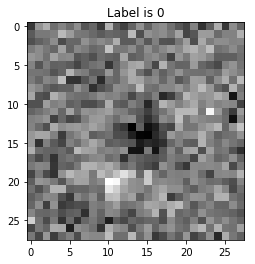

0.0


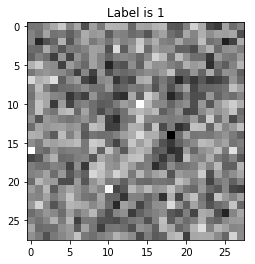

0.0


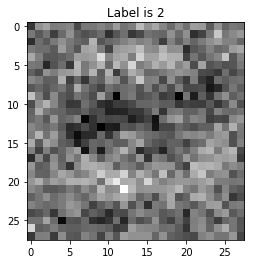

1.27553e-05


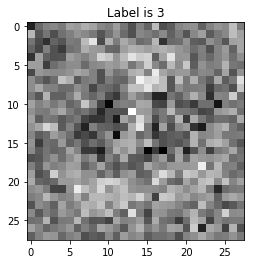

0.0


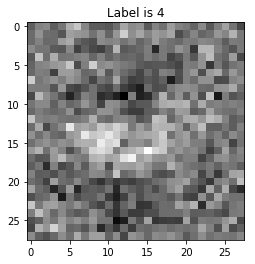

0.0


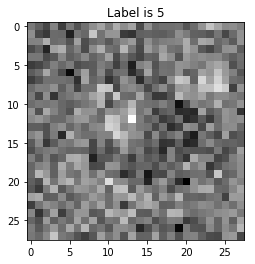

4.1484e-05


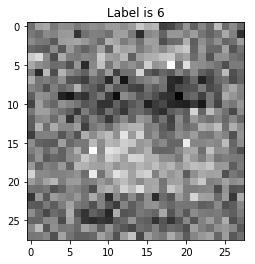

0.0


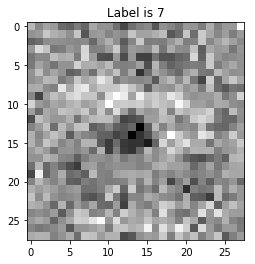

0.000374247


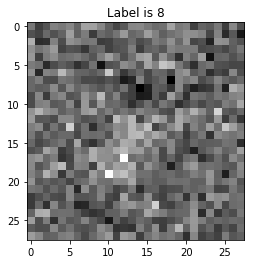

0.000706066


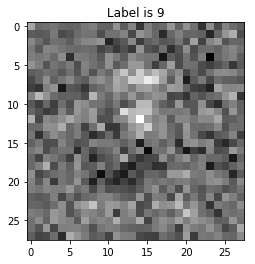

In [17]:
tf.get_variable_scope().reuse_variables()

# На обученной моделе сделаем входную картинку переменной
with tf.Session() as sess:
    # Восстановим модель
    img = tf.Variable(tf.truncated_normal(shape=[1, 784], stddev=0.1))
    layer1 = tf.nn.relu(tf.matmul(img, W1_const) + b1_const)
    layer2 = tf.nn.relu(tf.matmul(layer1, W2_const) + b2_const)
    y = tf.matmul(layer2, W3_const) + b3_const
    for num in range(10):
        # Определим функцию потерь в зависимости от нужной цифры
        loss = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                labels=[num],
                logits=y
            )
        )

        train_step = tf.train.GradientDescentOptimizer(1).minimize(loss)

        sess.run(tf.global_variables_initializer())

        for _ in range(5):
            sess.run(train_step)

        # Распечатаем наши "красивые" цифорки
        print(sess.run(loss))
        image = np.asarray(sess.run(img)).reshape((28, 28))
        plt.title('Label is ' + str(num))
        plt.imshow(image, cmap="gray")
        plt.show()

### 4. Autoencoders
An autoencoder is an network used for unsupervised learning of efficient codings. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for the purpose of dimensionality reduction. Also, this technique can be used to train deep nets.

Architecturally, the simplest form of an autoencoder is a feedforward net very similar to the multilayer perceptron (MLP), but with the output layer having the same number of nodes as the input layer, and with the purpose of reconstructing its own inputs. Therefore, autoencoders are unsupervised learning models. An autoencoder always consists of two parts, the encoder and the decoder. Encoder returns latent representation of the object (compressed representation, usuallu smaller dimension), but decoder restores object from this latent representation. Autoencoders are also trained to minimise reconstruction errors (e.g. MSE).

Various techniques exist to prevent autoencoders from learning the identity and to improve their ability to capture important information:
1. Denoising autoencoder - take a partially corrupted input.
2. Sparse autoencoder - impose sparsity on the hidden units during training (whilst having a larger number of hidden units than inputs).
3. Variational autoencoder models inherit autoencoder architecture, but make strong assumptions concerning the distribution of latent variables.
4. Contractive autoencoder - add an explicit regularizer in objective function that forces the model to learn a function that is robust to slight variations of input values.

#### Exercises
1. Train 2 layers autoencoder that compressed mnist images to $\mathbb{R}^3$ space.
2. For each digit plot several samples in 3D axis (use "%matplotlib notebook" mode or plotly). How do digits group?
3. Train autoencoder with more layers. What are results?
4. Use autoencoder to pretrain 2 layers (unsupervised) and then train the following layers with supervised method.

In [55]:
# Напишем функцию для автоинкодера
def autoencoder(
        sizes=[784, 10],          # Размеры промежуточных слоев
        nonlinearity="leakyrelu", # Нелинейность между слоями
        alpha=0.1,                # Коэффициент альфа для LeakyReLU
        lambda1 = 0.0,            # Коэффициент при регулизации L1
        lambda2 = 0.0,            # Коэффициент при регулизации L2
        grad_speed=0.5,           # Коэффициент градиентного спуска
        epoches=5,                # Количество эпох
        batch_size=64,            # Размер батча
        parts=5,                  # Количетсво частей,
                                    # на которые мы делим данные при кросс-валидации
        cross_valid=False         # Флаг использования кросс-валидации(проверка на всех частях)
):
    
    # Удалим предыдущие переменные и граф
    tf.get_variable_scope().reuse_variables()
    tf.reset_default_graph()

    # Сделаем так, чтобы первый слой был размера 784 и размеры всех слоёв симметричны
    if sizes[0] != 784:
        sizes.insert(0, 784)

    n = len(sizes)
    for i in range(len(sizes) - 1):
        sizes.append(sizes[n - i - 2])

    # Количество слоев
    n = len(sizes)


    # Определим функцию активации
    activation = 0
    if nonlinearity == "sigmoid":
        activation = tf.nn.sigmoid
    elif nonlinearity == "relu":
        activation = tf.nn.relu
    elif nonlinearity == "leakyrelu":
        def leaky_relu(features):
            return tf.nn.relu(features) - alpha * tf.nn.relu(features)
        activation = leaky_relu
    else:
        raise RuntimeError("I don't know this function")

        
    # Определение переменных
    x = tf.placeholder(tf.float32, shape=[None, 784], name="data")
    
    # Добавим слои в цикле в список (кроме последнего)
    x_interim = list()
    x_interim.append(x)
    for i in range(1, n - 1):
        if lambda1 == 0 and lambda2 == 0:
            x_interim.append(
                tf.layers.dense(
                    inputs=x_interim[i - 1],
                    units=sizes[i],
                    activation=activation,
                    use_bias=True,
                    name="x" + str(i)
                )
            )
        else:
            x_interim.append(
                tf.layers.dense(
                    inputs=x_interim[i - 1],
                    units=sizes[i],
                    activation=activation,
                    use_bias=True,
                    kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(
                        scale_l1=lambda1,
                        scale_l2=lambda2
                    ),
                    name="x" + str(i)
                )
            )

    # Последний слой без нелинейности
    y = 0
    if lambda1 == 0 and lambda2 == 0:
        y = tf.layers.dense(
                inputs=x_interim[-1],
                units=sizes[-1],
                use_bias=True,
                name="y"
        )
    else:
        y = tf.layers.dense(
                inputs=x_interim[-1],
                units=sizes[-1],
                use_bias=True,
                kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(
                    scale_l1=lambda1,
                    scale_l2=lambda2
                ),
                name="y"
        )
    x_interim.append(y)
    cross_entropy = tf.reduce_sum(tf.square(x - y))

    train_step = tf.train.GradientDescentOptimizer(grad_speed).minimize(cross_entropy)


    with tf.Session() as sess:
        writer = tf.summary.FileWriter("/tmp/log/tensorflow/lab-2", sess.graph)
        for X_train, Y_train, X_test, Y_test in cross_validation(data,
                                                                 labels,
                                                                 parts,
                                                                 cross_valid=cross_valid
                                                                ):
            sess.run(tf.global_variables_initializer())
            for i in range(epoches):
                for batch_x, batch_y in next_batch(X_train, Y_train, batch_size):
                    sess.run(train_step, feed_dict={x: batch_x})

        images = sess.run(y, feed_dict={x: data[:5]})
        for i in range(2):
            img = np.asarray(images[i]).reshape((28, 28))
            plt.title('Label is ' + str(labels[i]))
            plt.imshow(img, cmap='gray')
            plt.show()
        writer.close()
    model = list()
    for i in range((n + 1) // 2):
        w = tf.get_default_graph().get_tensor_by_name(
          split(x_interim[i + 1].name)[0] + '/kernel:0')
        b = tf.get_default_graph().get_tensor_by_name(
          os.path.split(x_interim[i + 1].name)[0] + '/bias:0')
        model.append((w, b))
    return model

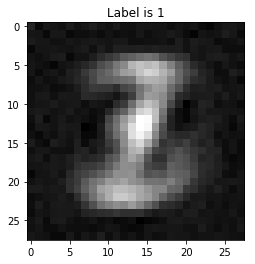

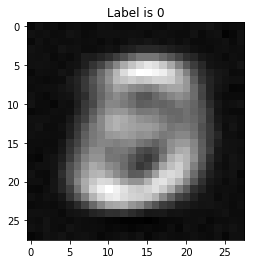

NameError: name 'split' is not defined

In [56]:
model = autoencoder(sizes=[784, 200, 3], epoches=2, grad_speed=5*1e-5)
print(len(model), len(model[0]), model[0][0])